In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D , MaxPooling2D , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras import Model

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow_datasets as tfds

In [3]:
dataset , info = tfds.load("svhn_cropped", split = "train"  ,with_info = True)

In [4]:
ds_test = tfds.load("svhn_cropped", split = "test")

In [5]:
info

tfds.core.DatasetInfo(
    name='svhn_cropped',
    full_name='svhn_cropped/3.0.0',
    description="""
    The Street View House Numbers (SVHN) Dataset is an image digit recognition
    dataset of over 600,000 digit images coming from real world data. Images are
    cropped to 32x32.
    """,
    homepage='http://ufldl.stanford.edu/housenumbers/',
    data_path='C:\\Users\\aeroa\\tensorflow_datasets\\svhn_cropped\\3.0.0',
    file_format=tfrecord,
    download_size=1.47 GiB,
    dataset_size=1.07 GiB,
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'extra': <SplitInfo num_examples=531131, num_shards=8>,
        'test': <SplitInfo num_examples=26032, num_shards=1>,
        'train': <SplitInfo num_examples=73257, num_shards=1>,
    },
    citation=""""""Street View House Numbers (SVHN) Da

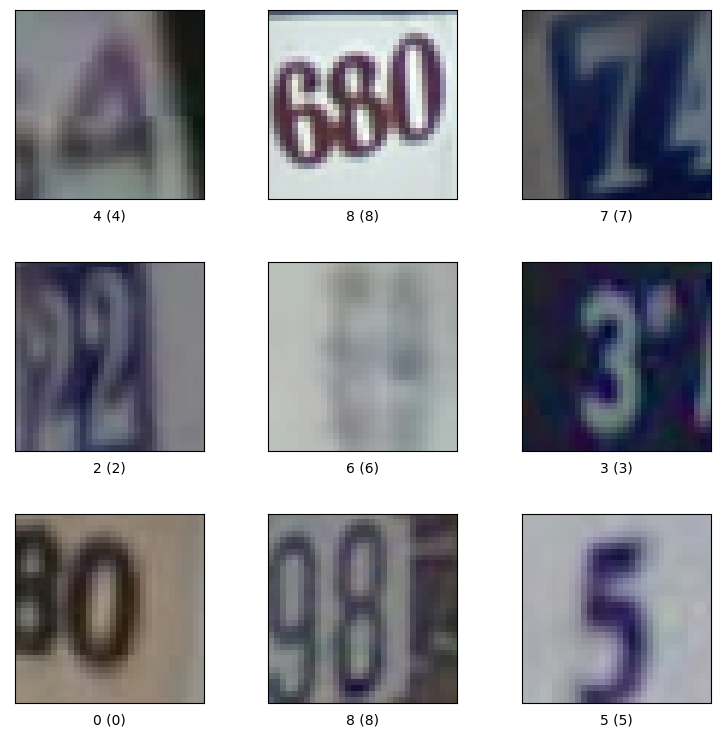

In [6]:
fig = tfds.show_examples(ds = dataset.take(12), ds_info=info)

In [7]:
batch_size = 256
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Build model

In [8]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.conv1 = Conv2D(8, 3 , padding='same' ,  activation='relu') 
        self.max1 = MaxPooling2D(pool_size = 2)
        self.conv2 = Conv2D(16 , 3 , padding='same' , activation='relu')
        self.max2 = MaxPooling2D(pool_size = 2)
        self.flatten = Flatten()
        self.d1 = Dense(64 , activation = 'relu')
        self.d2 = Dense(10  , activation = 'softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.max1(x)
        
        x = self.conv2(x)
        x = self.max2(x)
        
        
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

In [9]:
model = MyModel()
model.build(input_shape = (None,32,32,3))
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  224       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  1168      
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  656

In [10]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [11]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [12]:
@tf.function
def train_step(x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(y_train, predictions)

In [13]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

# Train

In [14]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    for i in dataset:
        images = i["image"]
        labels = i["label"]
        resized_images = tf.map_fn(lambda image: np.resize(image, (32,32,3)), images)
        train_step(tf.cast(resized_images , tf.float32) / 255.0 , labels)
        
    for ds in ds_test:
        images = ds["image"]
        labels = ds["label"]
        resized_images = tf.map_fn(lambda image: np.resize(image, (32,32 , 3)), images)
        test_step(tf.cast(resized_images , tf.float32) / 255.0 , labels)
    
    print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result()}, '
    f'Val Loss: {test_loss.result()}, '
    f'Val Accuracy: {test_accuracy.result()}, '
  )

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1, Loss: 1.7313165664672852, Accuracy: 0.4075241982936859, Val Loss: 1.0722564458847046, Val Accuracy: 0.6908036470413208, 
Epoch 2, Loss: 0.8710314631462097, Accuracy: 0.7461539506912231, Val Loss: 0.7864605188369751, Val Accuracy: 0.7828058004379272, 
Epoch 3, Loss: 0.6967830657958984, Accuracy: 0.8014114499092102, Val Loss: 0.7093781232833862, Val Accuracy: 0.8089658617973328, 
Epoch 4, Loss: 0.6236057281494141, Accuracy: 0.8249723315238953, Val Loss: 0.6778121590614319, Val Accuracy: 0.8183389902114868, 
Epoch 5, Loss: 0.5810951590538025, Accuracy: 0.838418185710907, Val Loss: 0.6460896134376526, Val Accuracy: 0.8277120590209961, 
Epoch 6, Loss: 0.5524727702140808, Accuracy: 0.8460078835487366, Val Loss: 0.6249563097953796, Val Accuracy: 0.8343192934989929, 
Epoch 7, Loss: 0.531445324420929, Accuracy: 0.8529424071311951, Val Loss: 0.6133324503898621, Val Accuracy: 0.8382375240325928, 
Epoch 8, Loss: 0.5153921246528625, Accuracy: 0.8573788404464722, Val Loss: 0.604673683643341

# Save model

In [15]:
tf.saved_model.save(model , 'model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
